# 03_dislo_analysis: Finding Atoms in the Dislocation Core

The purpose of this Jupyter Notebook is to isolate atoms in the dislocation core. The data used to do this is extracted from the previous step (02_minimize_dislo).

The general workflow of this notebook involves the following:
- Step 1: Import libraries and set input data paths.
- Step 2: Extract the necessary dump data from the dump files produced by LAMMPS simulation.
- Step 3: Filter the necessary data to find atoms in the dislocation core. 
- Step 4: Save the ID's (Particle Identifiers) of the atoms in the dislocation core for future simulations.

The end result of this Jupyter Notebook will be a textfile containing a list of particle ID's, that tell you which atoms are in the dislocation core. Moreover, the order of the ID's is given in the atoms distance from the center of the simulation box along the Z-axis. (I really hope that makes sense).

## Step 1: Import Libraries and Set Input Data Paths

This is the easy part (hopefully). It is recommended that you run this Jupyter Notebook with the 'Analysis' Conda Environment which can be found and exported from '000_conda_envs' in the root directory of this repository.

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

input_dir = '../02_minimize_dislo/min_dump'
input_file = 'straight_edge_dislo_dump'

dislo_dump_path = os.path.join(input_dir, input_file)

## Step 2: Extracing dump data

Now that we have the input paths to the dump files and have imported libraries, we can start extracting the data. The cell below contains two functions:
1) extract_box_data()

This function looks at the dump file produced by LAMMPS and extracts the dimensions of the simulation box. This information will be important for later things, such as plotting graphs and filtering data based on position. This function returns a dictionary containing the minimium and maximum coodinates on the x, y and z planes.

2) extract_atom_data()

This function looks at the dump file and extracts the atom information. This includes the x, y, and z position of each individual item. It will also collect the particle ID's and the potential energy of each atom (c_peratom).

In [76]:
def extract_box_data(input_path):
    """
    Extracts the simulation box boundaries from a LAMMPS dump file.

    Parameters:
    -----------
    input_path : str
        Path to the LAMMPS dump file.

    Returns:
    --------
    dict
        Dictionary with keys 'xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi' representing
        the lower and upper bounds of the simulation box in each dimension.

    Notes:
    ------
    This function looks for the line containing "ITEM: BOX BOUNDS" and
    reads the next three lines for the x, y, and z bounds respectively.
    """
    box_bounds = {}
    with open(input_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: BOX BOUNDS" in line:
                x_bounds = list(map(float, lines[i+1].split()))
                y_bounds = list(map(float, lines[i+2].split()))
                z_bounds = list(map(float, lines[i+3].split()))
                box_bounds = {
                    'xlo': x_bounds[0], 'xhi': x_bounds[1],
                    'ylo': y_bounds[0], 'yhi': y_bounds[1],
                    'zlo': z_bounds[0], 'zhi': z_bounds[1],
                }
                break
    return box_bounds

def extract_atom_data(input_path):
    """
    Extracts atom data from a LAMMPS dump file into a pandas DataFrame.

    Parameters:
    -----------
    input_path : str
        Path to the LAMMPS dump file.

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the atom data with columns corresponding to the
        headers listed after "ITEM: ATOMS" in the dump file.

    Notes:
    ------
    This function searches for the line containing "ITEM: ATOMS", reads
    the column headers from that line, and then reads all following lines
    as numerical atom data.
    """
    with open(input_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if "ITEM: ATOMS" in line:
                # Extract column headers from the line, ignoring the first two words
                headers = line.strip().split()[2:]
                data_start = i + 1
                break
    # Read atom data lines
    data_lines = lines[data_start:]
    # Convert each line to a list of floats
    data = [list(map(float, l.strip().split())) for l in data_lines]
    # Create DataFrame
    df = pd.DataFrame(data, columns=headers)
    return df

box = extract_box_data(dislo_dump_path)
atom_df = extract_atom_data(dislo_dump_path)

print("Box Dimensions:", box)
print("\nFirst few atoms:\n", atom_df.head())
print(f"\nNumber of atoms: {len(atom_df)}")

Box Dimensions: {'xlo': 0.0, 'xhi': 202.76507103393442, 'ylo': 0.0, 'yhi': 201.8987649155792, 'zlo': 0.0, 'zhi': 69.93978376383757}

First few atoms:
         id        x         y         z  c_peratom    c_csym  c_stress[1]  \
0  14951.0  66.9514   6.91273  0.980550   -2.88044  20.77780     457383.0   
1  13861.0  57.0250  10.92320  0.942169   -2.87617  21.14360     651233.0   
2  14129.0  57.8804  10.88700  3.330230   -3.08425  16.05880     367492.0   
3  14131.0  59.5444  10.85790  1.139810   -3.47319   5.84228     446893.0   
4  14401.0  60.4037  10.81380  3.517850   -3.65471   9.75565     706932.0   

   c_stress[2]  c_stress[3]  c_stress[4]  c_stress[5]  c_stress[6]  
0    -17323.30     151102.0     -8361.66     165516.0     383711.0  
1     -3246.59     143009.0    -79499.70     166164.0     375637.0  
2    -49297.30     154712.0     -8624.03     114826.0     333494.0  
3    112587.00     311608.0   -106040.00    -393366.0      75341.8  
4    498538.00     406178.0   -299817.00 

We can now plot the 3D atomistic data as a 3D scatter plot. To do this, we have the plot_atomistic_data_3d() function. This function takes the atom dataframe, the box dictionary and plots a 3D scatter graph of the atomistic data colour-coded to each atom's potential energy. Below I have defined the function. I have commented out the line:

"plot_atomistic_data_3d(atom_df, box)"

The reason for this is because (depending on your dataset) you can have a lot of atoms. Plotting this number of points (> 500,000) typically takes a long time and isn't very useful. If you'd like to plot it uncomment that line and hit run. If not, just run the cell to create the function.

In [80]:
def plot_atomistic_data_3d(atom_df, box, cmap='jet', alpha=0.8, s=2):
    """
    Plots a 3D scatter plot of atomistic data color-coded by c_peratom.

    Parameters:
        atom_df (pd.DataFrame): DataFrame containing 'x', 'y', 'z', and 'c_peratom' columns.
        box (dict): Dictionary with keys 'xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi' for axis limits.
        cmap (str): Colormap for coloring atoms by c_peratom.
        alpha (float): Transparency of points.
        s (int): Size of points.
    """
    required_cols = ['x', 'y', 'z', 'c_peratom']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")
    
    required_keys = ['xlo', 'xhi', 'ylo', 'yhi', 'zlo', 'zhi']
    if not all(k in box for k in required_keys):
        raise ValueError(f"Box must contain keys: {required_keys}")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    p = ax.scatter(atom_df['x'], atom_df['y'], atom_df['z'], 
                   c=atom_df['c_peratom'], cmap=cmap, alpha=alpha, s=s)

    ax.set_xlim(box['xlo'], box['xhi'])
    ax.set_ylim(box['ylo'], box['yhi'])
    ax.set_zlim(box['zlo'], box['zhi'])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    cbar = fig.colorbar(p, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label('Potential Energy per atom (eV)')

    plt.title('3D Atomistic Data')
    plt.tight_layout()
    plt.show()

## plot_atomistic_data_3d(atom_df, box)

## Step 3: Filtering Atomistic Data

So now that we have the dataset, we can start filtering out atoms. One way to do this is to find atoms of higher energy in the dataset and isolate them. Thats what the filter_atoms() function does. It takes the original atomic dataset and filters atoms out based on two parameters:

1) Potential Energy (c_thresh)

Dislocations are a line-based defect characterised by a misalignment of atomic planes in crystals. The misalignment of these atomic planes produce strain, as there are irregularities in the crystal structure. Because of this, atoms at the dislocation core (near to where the misalingment is) have a higher potential energy than that of atoms in a unaffected region of the crystal. c_thresh is the threshold energy that we assume when filtering atoms.

2) Distance from the middle Z-axis of the simulation box

In previous LAMMPS minimizations, we had fixed boundary conditions holidng atoms around the cylinder (along the x and y axis). This is necessary because of the way that LAMMPS works. By having fixed atoms at the edge of the simulation cylinder, we create high energy atoms but these are not atoms that we are interested in because they are an artefact of the limitations of this LAMMPS simulation procedure. Therefore we need to exclude them from our filtered dataset.

Below we have applied the filter_atoms() function to the original dataset, yielding a 'dislocation_df' dataframe. This is a dataframe contianing information about atoms in our dislocation. Also, to check that our dataset is okay, we can use the previous 3D scatter plot function to plot the dislocation. Ideally, you should see a line of atoms in the middle of the simulation cell. If you see a ring of atoms around the outside, you need to reduce the 'radius' parameter. If the dislocation looks really thick, then you need to reduce the c_thresh parameter.

8470

Number of atoms in the dislocaiton core: 270



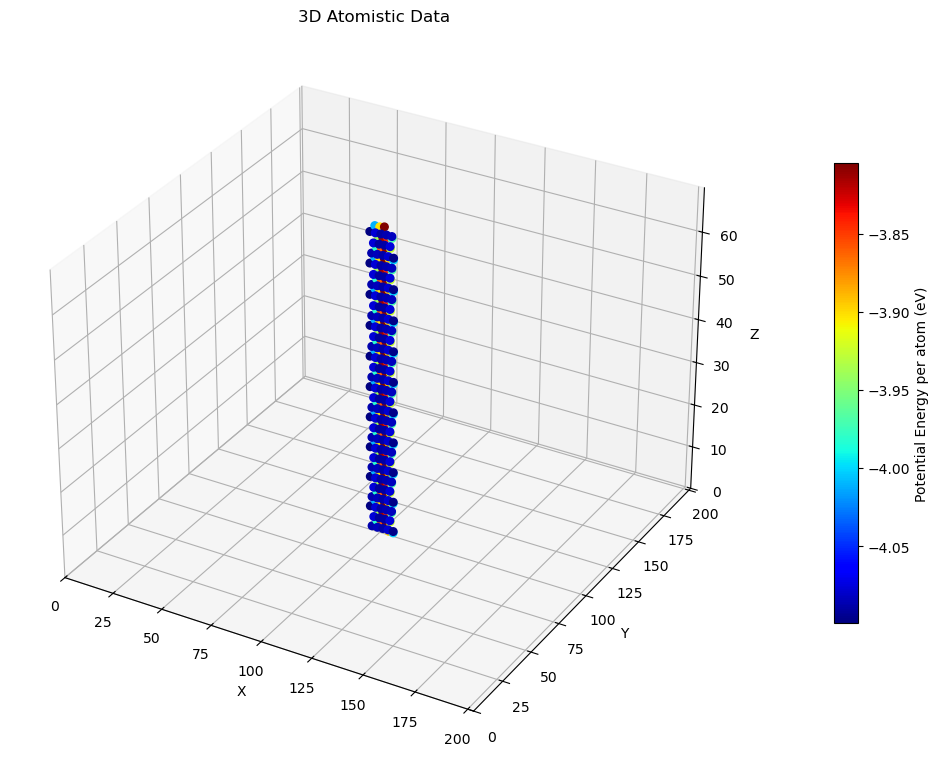

In [96]:
def filter_atoms(atom_df, box, radius, c_peratom_thresh, c_csym_thresh=1):
    """
    Filters atoms based on their per-atom charge and distance from the box center in the XY plane.

    Parameters:
    -----------
    atom_df : pandas.DataFrame
        DataFrame containing atom data with columns including 'x', 'y', and 'c_peratom'.
    box : dict
        Dictionary with simulation box boundaries, must contain keys:
        'xlo', 'xhi', 'ylo', 'yhi'.
    radius : float
        Radius distance from the box center within which atoms are selected.
    c_thresh : float, optional, default=-4.0
        Threshold value for the 'c_peratom' property. Only atoms with 'c_peratom' greater than
        this threshold will be included.

    Returns:
    --------
    pandas.DataFrame
        Filtered DataFrame containing atoms that satisfy both the per-atom charge threshold
        and are located within the specified radius from the box center in the XY plane.

    Notes:
    ------
    The function calculates the center of the simulation box in the XY plane and filters
    atoms by computing their Euclidean distance from this center. It then applies the
    charge threshold filter on 'c_peratom'.
    """
    # Calculate center coordinates of the simulation box in XY plane
    x_center = (box['xlo'] + box['xhi']) / 2
    y_center = (box['ylo'] + box['yhi']) / 2

    # Compute XY-plane distance of each atom from the box center
    dx = atom_df['x'] - x_center
    dy = atom_df['y'] - y_center
    r_xy_cond = np.sqrt(dx**2 + dy**2)

    # Compute the atoms that satisfy the peratom condition
    peratom_cond = atom_df['c_peratom'] > c_peratom_thresh

    # Compute the atoms that satisfy the centrosymmetry condition
    csym_cond = atom_df['c_csym'] > c_csym_thresh

    print(csym_cond.sum())

    # Apply filters: 'c_peratom' above threshold AND distance within radius
    filtered_df = atom_df[(peratom_cond | csym_cond) & (r_xy_cond < radius)]

    return filtered_df

dislocation_df = filter_atoms(atom_df, box, radius=20, c_peratom_thresh=-3.8, c_csym_thresh=2)
print(f"\nNumber of atoms in the dislocaiton core: {len(dislocation_df)}\n")

plot_atomistic_data_3d(dislocation_df, box, s=30, alpha=1)

In [102]:
def split_dislocation(dislocation_df):

    tensile_side = dislocation_df[dislocation_df['c_stress[1]'] < 0]
    comrpessive_side = dislocation_df[dislocation_df['c_stress[1]'] > 0]

    return tensile_side, comrpessive_side

ten_dislo_df, comp_dislo_df = split_dislocation(dislocation_df)

In order to get a better picture, we can just make a 2D scatter plot of the data, which is what we've done below.

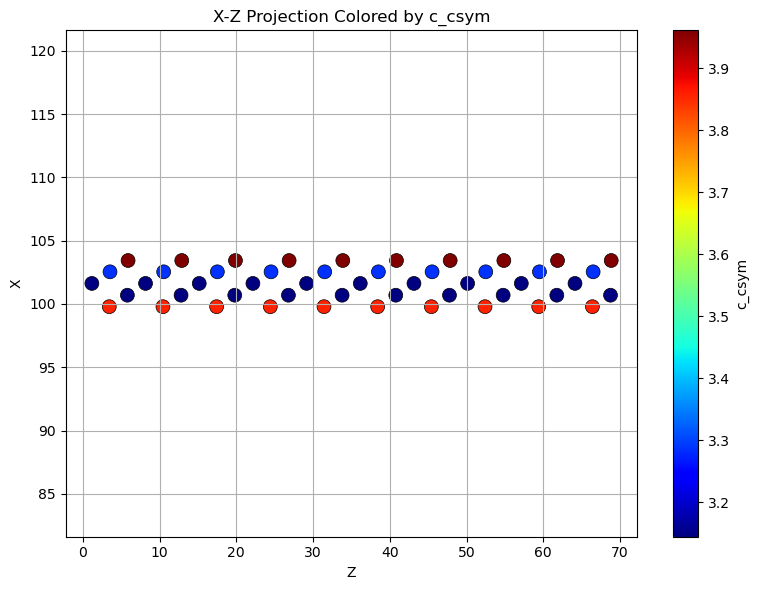

In [ ]:
def plot_xz_colored_by_csym(atom_df, cmap='jet', s=100, alpha=1, buffer=20, csym_thresh=None):
    """
    Plots a 2D scatter plot with Z on X-axis and X on Y-axis, colored by c_csym,
    and optionally filters atoms based on a centrosymmetry threshold.

    Parameters:
    -----------
    atom_df : pd.DataFrame
        Must contain 'x', 'z', 'c_peratom', and 'c_csym' columns.

    cmap : str, optional
        Colormap for c_csym. Default is 'jet'.

    s : float, optional
        Size of scatter points. Default is 100.

    alpha : float, optional
        Transparency of points. Default is 1.

    buffer : float or None, optional
        If provided, limits Y-axis (i.e., X-position of atoms) to [mean-buffer, mean+buffer].
        If None, Y-axis limits are determined automatically.

    csym_thresh : float or None, optional
        If provided, only atoms with 'c_csym' less than this value will be plotted.

    Raises:
    -------
    ValueError
        If required columns are missing in atom_df.
    """
    required_cols = ['x', 'z', 'c_peratom', 'c_csym']
    if not all(col in atom_df.columns for col in required_cols):
        raise ValueError(f"atom_df must contain the following columns: {required_cols}")

    # Apply c_csym threshold filter if specified
    if csym_thresh is not None:
        atom_df = atom_df[atom_df['c_csym'] < csym_thresh]

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(
        atom_df['z'], atom_df['x'],
        c=atom_df['c_csym'],
        cmap=cmap,
        s=s,
        alpha=alpha,
        edgecolors='black',
        linewidth=0.5
    )

    plt.xlabel('Z')
    plt.ylabel('X')
    plt.title('X-Z Projection Colored by c_csym')
    cbar = plt.colorbar(sc)
    cbar.set_label('c_csym')

    if buffer is not None:
        y_mid = atom_df['x'].mean()
        plt.ylim([y_mid - buffer, y_mid + buffer])

    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_xz_colored_by_csym(comp_dislo_df, csym_thresh=3.5)

## Step 4: Writing out the IDs of dislocation core atoms

Now that that's all over, we can finally isolate the ID's of atoms that are inside of the dislocation core. That is what the get_high_energy_atom_ids() function does. It takes our dataframe of dislocation core atoms and outputs their ID's into a textfile.

In this function, you'll notice that we are calculating the distance of each atom from the center point of the simulation box (along the Z-axis), because it will allow us to sort the atom ID's based on their distance from the center of the simulation box. This is important, because when we later begin deleting core atoms from the dislocation to produce jogs, we want to form the jogs in the middle of the dislocation.

In [73]:
def get_high_energy_atom_ids(atom_df, box):
    """
    Returns the IDs of atoms sorted by their absolute distance from the center of the 
    simulation box along the Z-axis. 

    Parameters:
    -----------
    atom_df : pandas.DataFrame
        DataFrame containing atom data. Must include the columns:
        - 'id' : Unique identifier for each atom.
        - 'z' : Z-coordinate of each atom.
        - 'c_peratom' : Per-atom energy or charge value (not filtered on in this version).

    box : dict
        Dictionary specifying simulation box boundaries with keys:
        - 'zlo' : Lower bound of the box along the Z-axis.
        - 'zhi' : Upper bound of the box along the Z-axis.

    Returns:
    --------
    list
        List of all atom IDs (integers or strings) sorted by their absolute distance 
        from the center of the box along the Z-axis.

    Side Effects:
    -------------
    Creates a text file named 'deleted_ids.txt' in the current working directory,
    containing the sorted list of atom IDs, one per line.

    Raises:
    -------
    ValueError
        If the input DataFrame does not contain required columns 'id' or 'z'.

    Notes:
    ------
    - The function calculates the center of the box in Z by averaging 'zlo' and 'zhi'.
    - No filtering is done on 'c_peratom'; all atoms are included.
    - Atoms are sorted by how close their Z coordinate is to the box center.
    """
    if not all(col in atom_df.columns for col in ['id', 'z', 'c_peratom']):
        raise ValueError("atom_df must contain 'id', 'z', and 'c_peratom' columns")

    z_center = (box['zlo'] + box['zhi']) / 2

    # Filter for high-energy atoms
    dis_core_atoms = atom_df.copy()

    # Calculate distance from center in Z
    dis_core_atoms['z_dist'] = (dis_core_atoms['z'] - z_center).abs()

    # Sort by distance to Z center
    sorted_atoms = dis_core_atoms.sort_values(by='z_dist')

    # Extract sorted IDs
    sorted_ids = sorted_atoms['id'].tolist()

    # Save to file
    filepath = 'deleted_ids.txt'
    with open(filepath, 'w') as f:
        for aid in sorted_ids:
            f.write(f"{aid}\n")

    return sorted_ids

get_high_energy_atom_ids(dislocation_df, box)

[94350.0,
 94351.0,
 94050.0,
 112919.0,
 75482.0,
 113219.0,
 75481.0,
 113220.0,
 75181.0,
 131788.0,
 56613.0,
 132088.0,
 56612.0,
 132089.0,
 56312.0,
 150657.0,
 37744.0,
 150957.0,
 37743.0,
 150958.0,
 37443.0,
 169526.0,
 18875.0,
 169826.0,
 18874.0,
 169827.0,
 18574.0,
 188395.0,
 6.0,
 5.0]